# Problem Statement

Car ownership is a significant part of one's identity, and along with house ownership, a significant achievement of one's life. Especially in the luxury car market, car communities can form around shared interests, goals, and passions in life. You are a data scientist hired by a marketing and advertising firm and you are interested in performing market segmentation of the luxury car market to determine whether the clientele of Lamborghini and Tesla differ systematically in occupations, personality traits, passions/interests and political affiliations. To perform this market segmentation task, you scrape posts from Reddit and consolidate 5k posts from Tesla and 5k from Lamborghini. You use NLP (a vectorizer with a classifier) to analyze the dataset and determine the best performing model by ROC-AUC because the ability to differentiate between enthusiasts of the two brands is pivotal to the success of this task.

To search for systematic differences between occupations, personalities, passions and political affiliation, you look for words that are most predictive of one's proclivity towards either brand.

# Table of Contents

1. Data cleaning
2. Data Visualization:
    - Section 1: Distributions of word length and word count
    - Section 2: Most common words found in the Title and selftext portions
    - Section 3: Most common bigrams
    - Section 4: Word Cloud

In [1]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
#from wordcloud import WordCloud
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.text import Text

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 

import gensim
from gensim.parsing.preprocessing import STOPWORDS

import warnings
warnings.simplefilter("ignore")

# Data Cleaning

In [2]:
tesla = pd.read_csv("data/tesla.csv")
lambo = pd.read_csv("data/lambo.csv")

In [3]:
tesla.columns

Index(['Unnamed: 0', 'subreddit', 'selftext', 'title', 'full_link'], dtype='object')

The function `data_cleaner` removes the following from the dataset because it has no value to the final analysis:

- Erroneous columns.
- Duplicates.
- Posts that are filtered as spam by the bots.
- Hyperlinks
- Symbols
- Numbers

In [4]:
def data_cleaner(df):
    try:
        df.drop(columns = "Unnamed: 0", inplace = True)
    except:
        pass
    df.drop_duplicates(keep = "first", inplace = True)
    df = df[df["selftext"] != "[removed]"]
    df["selftext"] = df["selftext"].str.replace(r"http[^ ]+","")
    df["selftext"] = df["selftext"].str.replace(r"[^\w\s]", "")
    df["selftext"] = df["selftext"].str.replace(r"[\d+]", "")
    return df

In [5]:
tesla = data_cleaner(tesla)
lambo = data_cleaner(lambo)

In [6]:
tesla.shape

(13626, 4)

In [7]:
lambo.shape

(5444, 4)

# Data Visualization

In [8]:
def title_length(df):
    df["title_length"] = df["title"].str.len()
    df["title_word_count"] = df["title"].str.split().str.len()
    return df

In [9]:
tesla = title_length(tesla)
lambo = title_length(lambo)

## Section 1: Distribution of Title Lengths & Wordcounts

Using descriptive statistics, I observed that Tesla posts have a longer title length and word count on average, which may imply that Tesla enthusiasts are more active on Reddit and write lengthier posts.

In [10]:
tesla.describe()

,title_length,title_word_count
count,13626.000000,13626.000000
mean,65.111258,11.593938
std,46.622564,8.585271
min,1.000000,1.000000
25%,34.000000,6.000000
50%,55.000000,10.000000
75%,80.000000,14.000000
max,303.000000,62.000000


In [11]:
lambo.describe()

,title_length,title_word_count
count,5444.000000,5444.000000
mean,47.878031,7.839273
std,33.308464,6.041840
min,1.000000,1.000000
25%,26.000000,4.000000
50%,41.000000,6.000000
75%,61.000000,10.000000
max,308.000000,61.000000


- Length of Lamborghini titles appear to have a significantly lower mean (47.87 as opposed to 65.11) and median (41 as opposed to 55) compared to Tesla.

- Standard deviation of title lengths and word counts are lower in Lamborghini compared to Tesla (46.622 vs 33.33)

- Significant right skew was detected in both data: while the 75th percentile score for Tesla title lengths & word count are 80 and 14 respectively, the max was 303 and 62 respectively. A similar observation can be found in the Lamborghini dataset.

## Section 2: Word Frequency Analysis Using CountVectorizer

This word frequency analysis allows us to spot any preliminary trends in the data, as well as add words which are too ubiquitous into the list of Gensim stopwords during the modelling stage. Refer to notebook #3 for details on the modelling stage

In [12]:
def subplotter(dfs, func):
    plt.subplot(1,2,1)
    func(dfs[0])
    plt.subplot(1,2,2)
    func(dfs[1])
    plt.show()

In [13]:
def word_counter(df, dropna = False):
    
    '''uses CountVectorizer to count word frequency and plot a bar chart'''
    
    x = df.copy()
    if dropna == True:
        x.dropna(inplace = True)
    
    cvec = CountVectorizer(stop_words = STOPWORDS)
    x = cvec.fit_transform(x)
    cvec_df = pd.DataFrame(x.todense(), 
                          columns=cvec.get_feature_names())
    return cvec_df.sum().sort_values(ascending = False).head(50).plot(kind = "barh", figsize = (21,21));


### Most Common Words found in Title

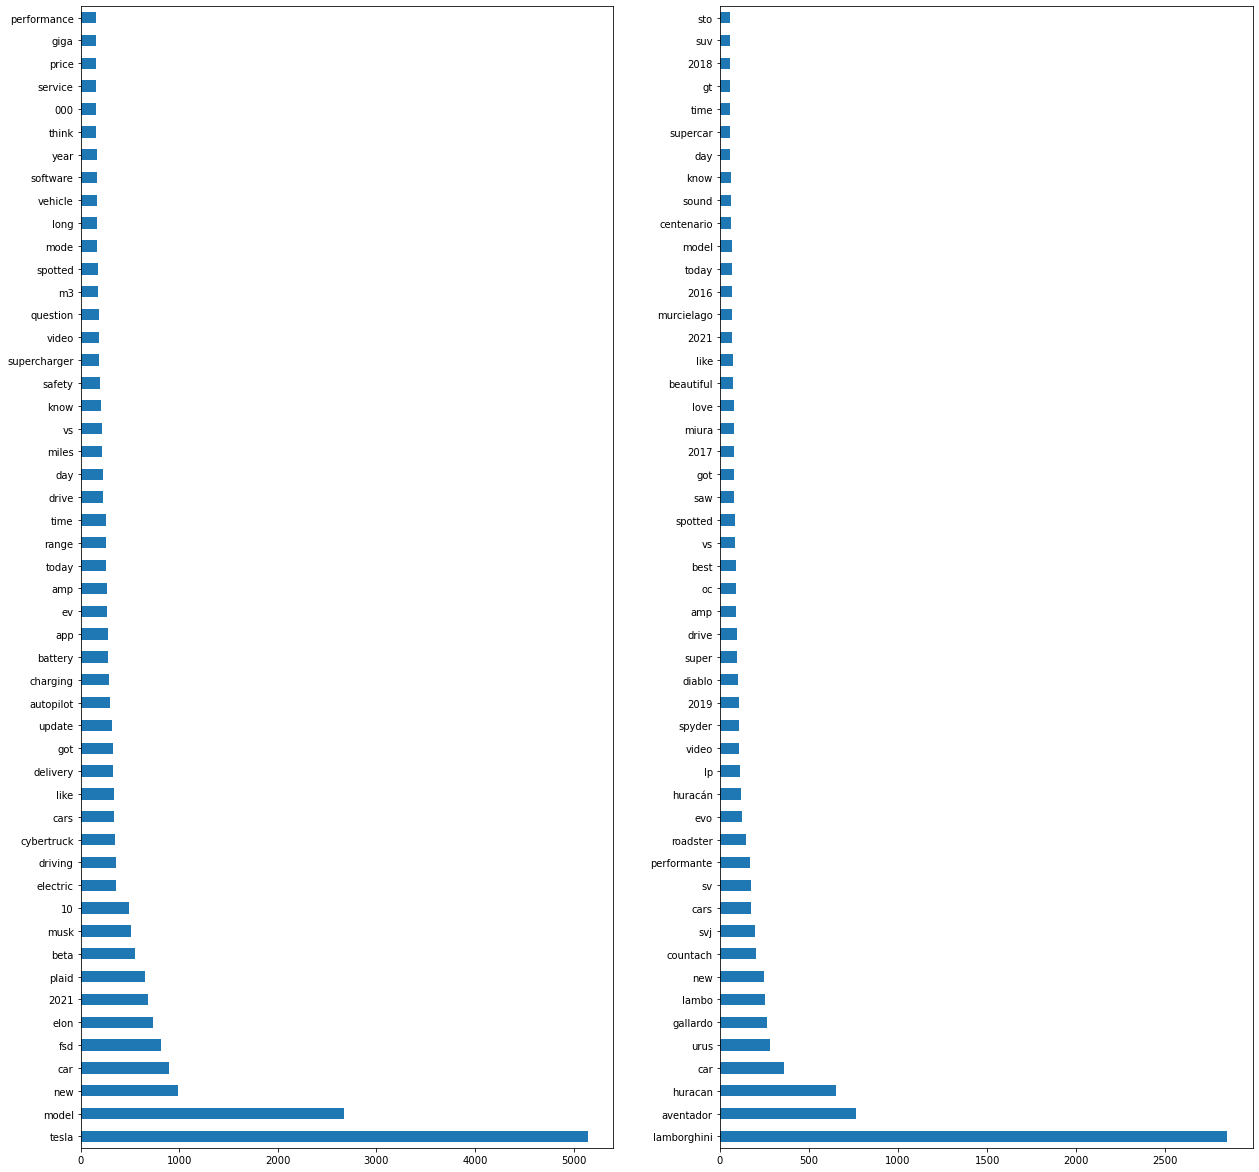

In [14]:
subplotter([tesla["title"], lambo["title"]], word_counter)

- The most common words in the Tesla dataset include words like driving, electric, fsd, elon, which suggest that self-driving cars and electric vehicles were the hottest topics of discussion.

- On the other hand, the most common words in the Lamborghini dataset include the names of its models, such as Aventador, Huracan, Urus, Diablo and so on.

### Most Common Words found in Selftext

In [15]:
def subplotter_2(dfs, func):
    plt.subplot(1,2,1)
    func(dfs[0], dropna = True)
    plt.subplot(1,2,2)
    func(dfs[1], dropna = True)
    plt.show()

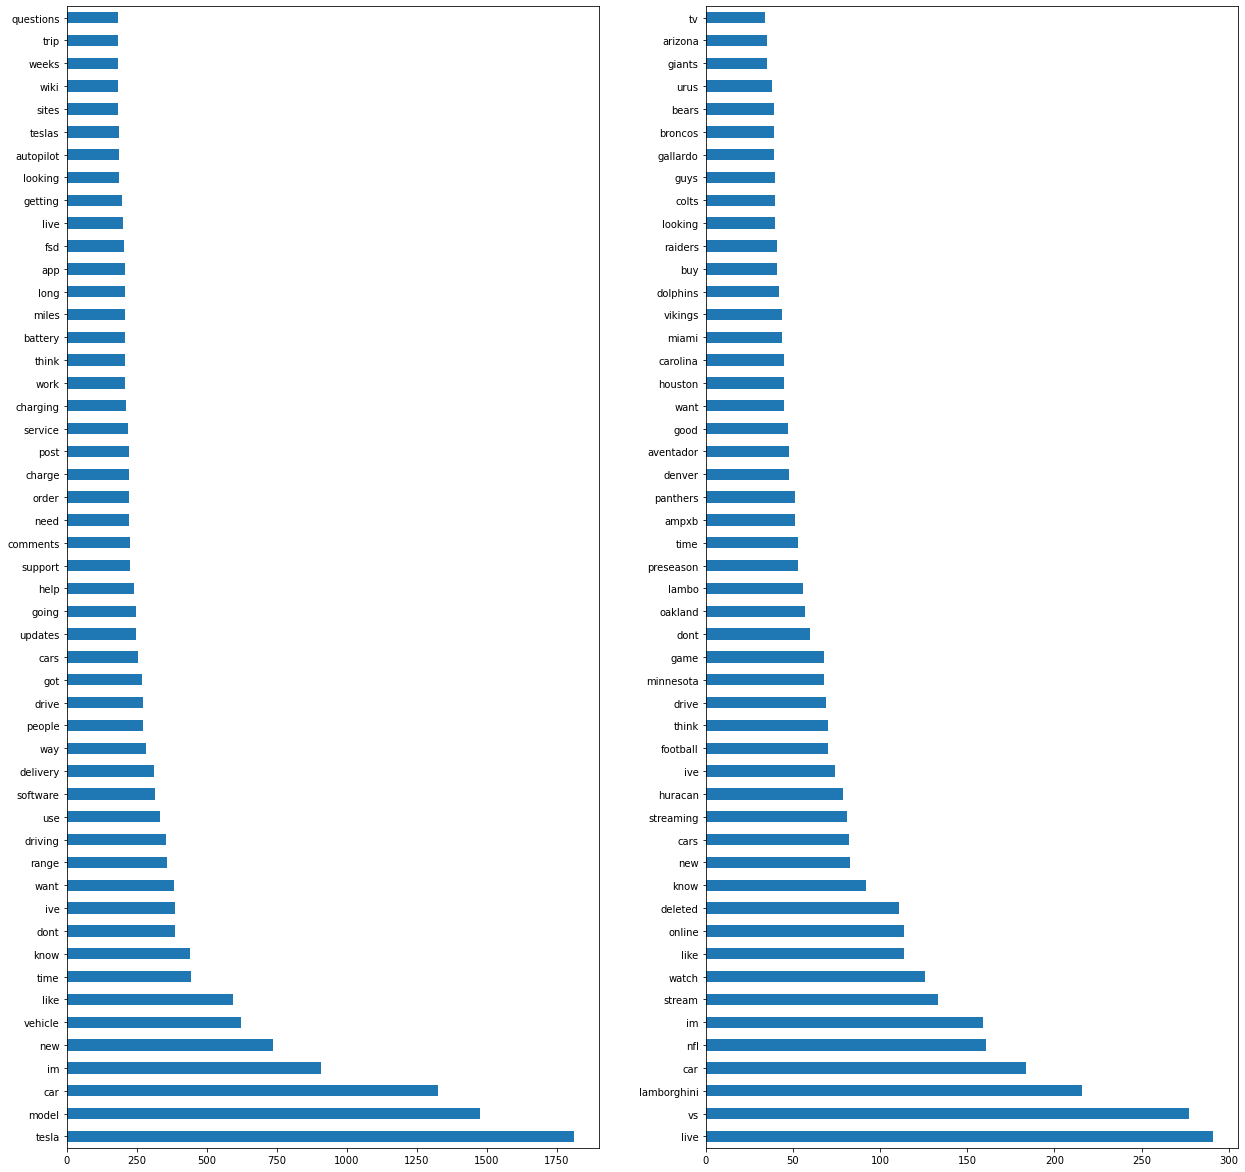

In [16]:
subplotter_2([tesla["selftext"], lambo["selftext"]], word_counter)

Analysis suggests that Lamborghini enthusiasts are also enthusiasts of American football dueto the prevalence of words such as NFL, football, game, preseason, Dolphins, Panters, Vikings, Raiders and Colt. American cities such as Minnesota, Miami, Denver and Houston also appear frequently in the dataset, which seem related to the matches between the NFL teams.

In contrast, the most common words in the Tesla selftext revealed no interesting insights.

## Section 3: Bigram Analysis

Bigram Analysis was performed on both title and selftext, which verified the results above.

In [17]:
def bigram_counter(df, dropna = False):
    x = df.copy()
    if dropna == True:
        x.dropna(inplace = True)
    
    cvec = CountVectorizer(ngram_range = (2,2), stop_words = STOPWORDS)
    x = cvec.fit_transform(x)
    cvec_df = pd.DataFrame(x.todense(), 
                          columns=cvec.get_feature_names())
    return cvec_df.sum().sort_values(ascending = False).head(50).plot(kind = "barh", figsize = (21,21));

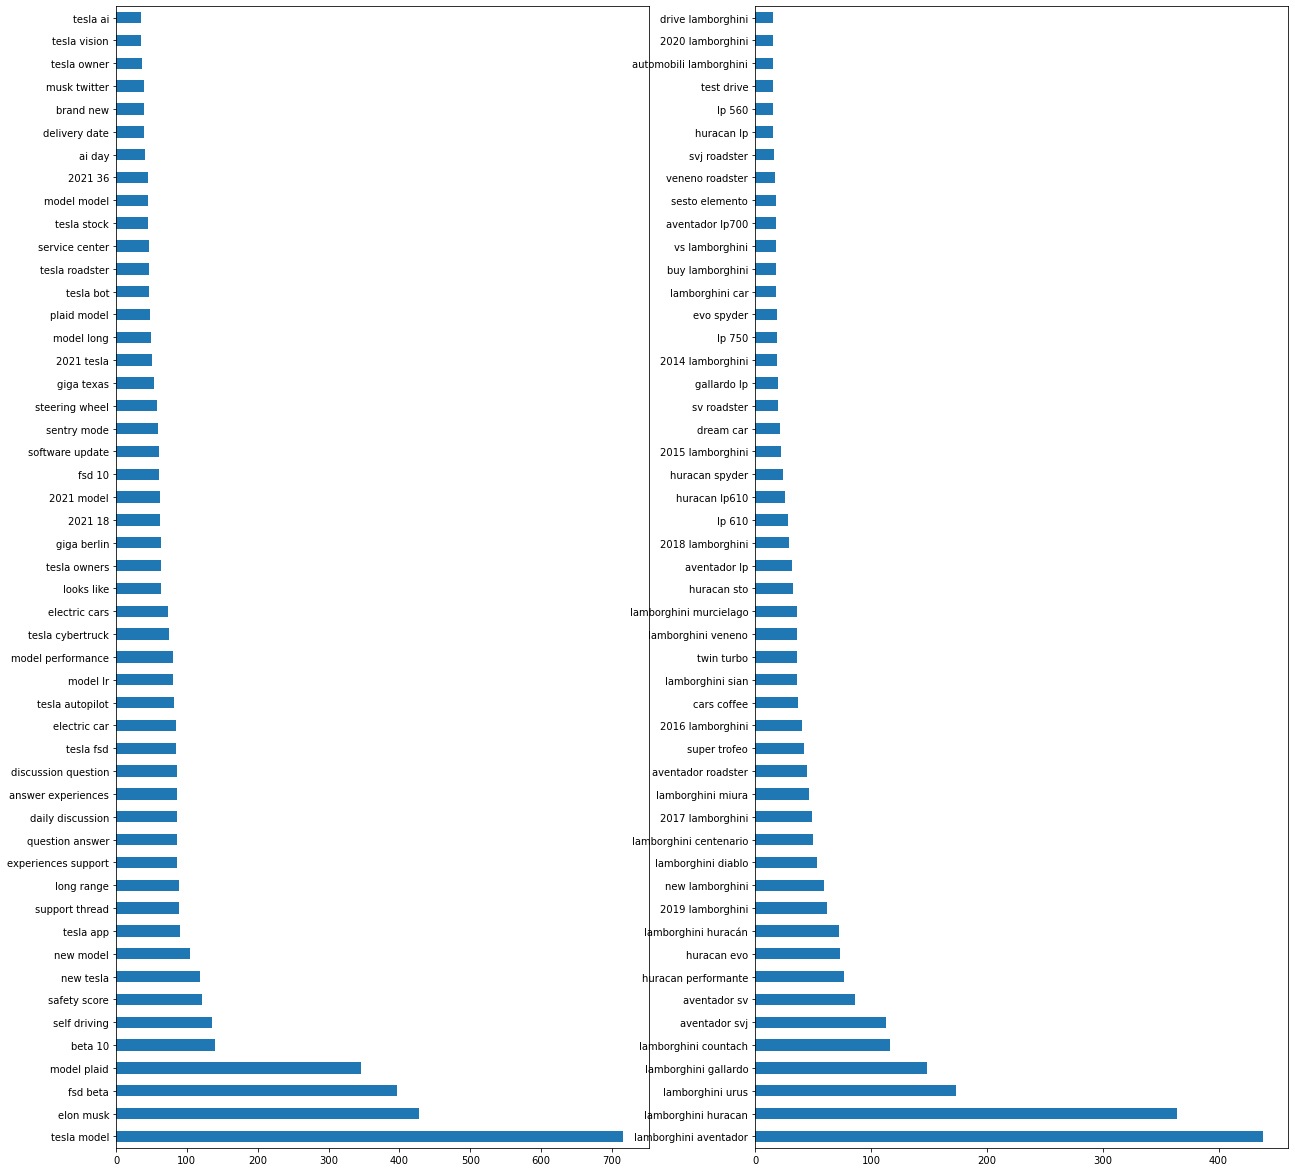

In [18]:
subplotter([tesla["title"], lambo["title"]], bigram_counter)

Bigram analysis of the Tesla titles confirmed the results above, with keywords like safety score, self driving, beta 10, model plaid etc being the most prevalent.

The most common words in the Lamborghini titles are its car models.

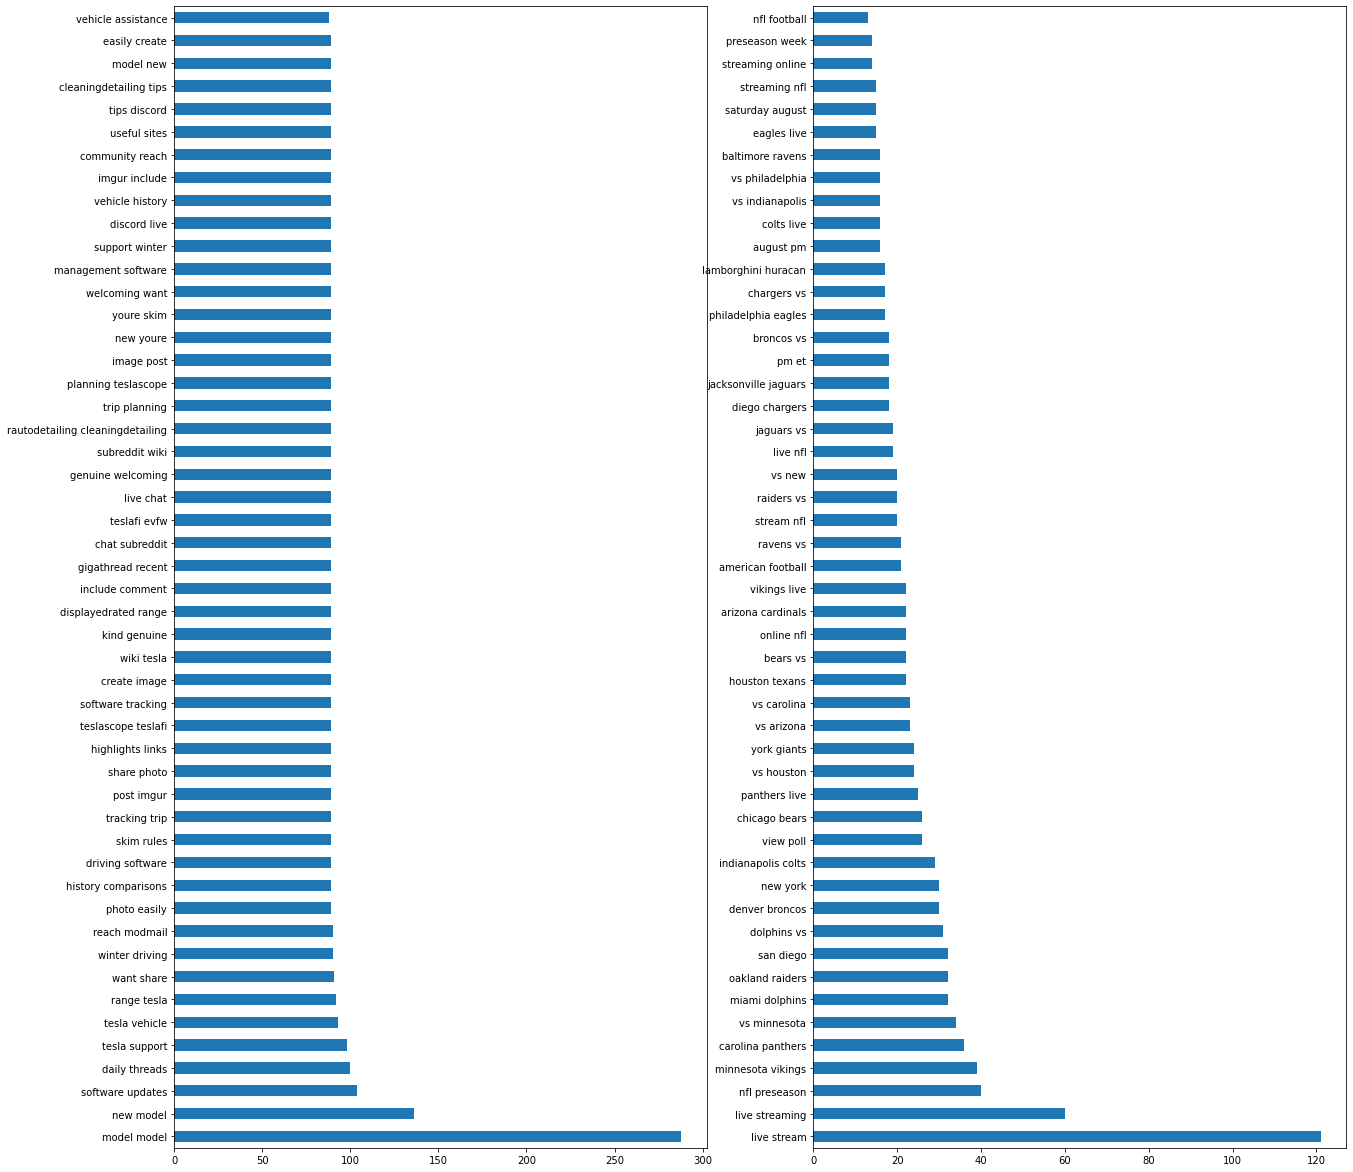

In [19]:
subplotter_2([tesla["selftext"], lambo["selftext"]], bigram_counter)

## Section 4: Word Cloud

![tesla_wc](Pictures/tesla_wc.png)

![lambo_wc](Pictures/lambo_wc.png)

A more visual representation of the top words in the dataset are shown here!

## Preprocessing

25k posts were scraped from the Tesla reddit but only 5k was scraped from the Lamborghini reddit. To ensure a balanced dataset, I included the 1788 selftext posts from Tesla and randomly sampled 3656 posts.

In [ ]:
print(lambo.shape)
tesla_st = tesla[tesla["selftext"] != "tesla"]
print(tesla_st.shape)
tesla_nst = tesla[tesla["selftext"] == "nan"]

In [ ]:
tesla_sampled = tesla_nst.sample(n = 3656, random_state = 42)

Mapping 0 to Tesla and 1 to Lamborghini.

In [ ]:
combined = pd.concat([tesla_st, tesla_sampled, lambo], ignore_index = True)
combined["y"] = combined["subreddit"].map({"teslamotors": 0, "lamborghini": 1})
combined["words"] = combined["title"] + " " + combined["selftext"]

In [ ]:
combined.to_csv("data/combined.csv")

## EDA Conclusion 

The preliminary EDA suggests that Tesla and Lamborghini enthusiasts differ systemically in terms of hobbies and topics discussed, and the nature of the brands are also extremely different.


A few differences between the branding:

- Elon Musk was frequently mentioned in Tesla posts, but not Ferrucio Lamborghini or the current CEO of Lamborghini, Stephen Winkelmann. This may suggest that the personal magnetism and visionary nature of Elon Musk plays a huge role in the branding of Tesla, similar to Steve Jobs' inseparability from Apple Inc. As a result, the words "Elon Musk" would be included in the list of stop words.


- Words correlated with technology, such as self-driving (FSD) cars, frequently appear in the Tesla dataset. On the other hand, words correlated with classic team sports, like "football" and "nfl" were among the top 50 most frequent words to appear, along with references to "Panthers" and "Dolphins". These are American football teams. This implies that the Tesla brand attracts tech enthusiasts, while the Lamborghini brand attracts people who value athleticism.